In [1]:
!pip3 install geopandas
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import geopandas as gpd
import pandas as pd
import ogr
import gdal
from sklearn import metrics
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from astropy.visualization import PercentileInterval

In [16]:
'''======  Configuration  ======'''

sat = 8  # 2-Seninel-2, 5-Landsat-5, 8-Landsat-8

if (sat==8):
    # 0-CA, 1-R, 2-G, 3-B, 4-NIR, 5-SWIR1, 6-SWIR2, 7-PC, 8-C, 9-TI1, 10-TI2
    dispBand = [4, 3, 2]
    requiredBands = ['', '', '', '', '', '', '', '', '', '', '', '']
elif (sat==5):
    # 0-R, 1-G, 2-B, 3-NIR1, 4-NIR2, 5-T, 6-MI
    dispBand = [0, 1, 2]
    requiredBands = ['', '', '']
elif (sat==2):
    # 0-R, 1-G, 2-B
    dispBand = [2, 1, 0]
    requiredBands = ['', '', '']

run_RF = True
run_DT = True
run_SVM = True
run_CNN = True

split_ROI = True

rootPath = "drive/My Drive/kota_setar/"
dataName = "KS2020.tif"

In [17]:
'''===========  Read Image Metadata  ============'''
inputFS = rootPath + dataName
driverTiff = gdal.GetDriverByName('GTiff')
inputDS = gdal.Open(inputFS)
numBands = inputDS.RasterCount

band_data = []
print('bands', inputDS.RasterCount, 'rows', inputDS.RasterYSize, 'columns', inputDS.RasterXSize)

for i in range(1, numBands+1):
    band = inputDS.GetRasterBand(i).ReadAsArray()
    band_data.append(band)

band_data = np.dstack(band_data)

bands 12 rows 1377 columns 1670


In [18]:
'''===========  Read Image Data  ============'''
def read_tif_and_get_bands(dataPath, dataName, requiredBands):
    raster = gdal.Open(dataPath + dataName)

    data = raster.ReadAsArray(0,0)
    mask = raster.GetRasterBand(1).GetMaskBand().ReadAsArray(0,0)

    bandNameList = []
    numBands = raster.RasterCount
    print("numBands", numBands)

    if len(data.shape) == 2:
        data = data[np.newaxis, ...]

    DATA = np.zeros([len(requiredBands), data.shape[1], data.shape[2]])

    cnt = 0
    print("------ {} --------".format(dataName))
    for i in range(numBands):
        rasterBand = raster.GetRasterBand(i+1)
        bandName = rasterBand.GetDescription()
        print("bandName: {}".format(bandName))
        bandNameList.append(bandName)
        if bandName in requiredBands:
            DATA[cnt, ...] = data[i, ...]
            cnt = cnt + 1

    if cnt != len(requiredBands):
      print("----------------------------------------------------")
      print("There is no required bands: {}".format(requiredBands))
      DATA, mask = None, None

    return DATA, mask[np.newaxis, ...]/255

inputData0, _ = read_tif_and_get_bands(rootPath, dataName, requiredBands)
interval = PercentileInterval(98.0)

for idx in range(0, inputData0.shape[0]):
    inputData0[idx, :, :] = interval(inputData0[idx, ...])
inputData = inputData0.transpose(1, 2, 0)

print(inputData.shape)


numBands 12
------ KS2020.tif --------
bandName: 
bandName: 
bandName: 
bandName: 
bandName: 
bandName: 
bandName: 
bandName: 
bandName: 
bandName: 
bandName: 
bandName: 
(1377, 1670, 12)


Felzenszwalb number of segments: 4844
SLIC number of segments: 2838
Quickshift number of segments: 12417
Watershed number of segments: 2576


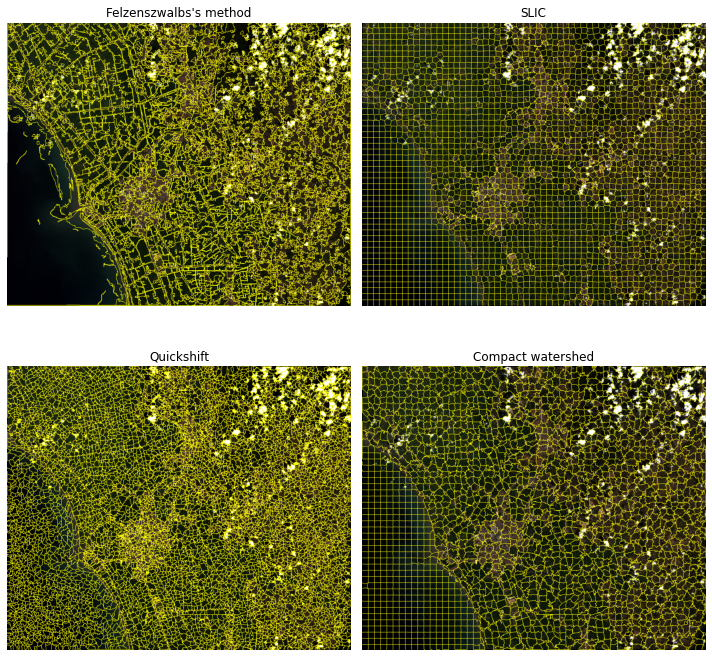

In [19]:
'''  ======= Segmentation  =========  '''
# img = exposure.rescale_intensity(band_data)
img = inputData[:, :, dispBand]

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=3000, compactness=30)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=2500, compactness=0.001)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")
print(f"Watershed number of segments: {len(np.unique(segments_watershed))}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

plt.imsave(rootPath + "fz_seg.png", mark_boundaries(img, segments_fz, color=(0.8, 0, 0)))
plt.imsave(rootPath + "slic_seg.png", mark_boundaries(img, segments_slic, color=(0.8, 0, 0)))
plt.imsave(rootPath + "quick_seg.png", mark_boundaries(img, segments_quick, color=(0.8, 0, 0)))
plt.imsave(rootPath + "watershed_seg.png", mark_boundaries(img, segments_watershed, color=(0.8, 0, 0)))

In [6]:
'''  =========== Describe Segments ==============  '''
segments = segments_quick # segments_fz, segments_slic, segments_quick, segments_watershed

def segment_features(segment_pixels):
    features = []
    npixels, numBands = segment_pixels.shape
    for b in range(numBands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            # in this case the variance = nan, change it 0.0
            band_stats[3] = 0.0
        features += band_stats
    return features

segment_ids = np.unique(segments)
objects = []
object_ids = []
for id in segment_ids:
    segment_pixels = img[segments_quick == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
''' =========== Separate Training and Testing Data ======= '''
if split_ROI:
    # Read shapefile to geopandas geodataframe
    gdf = gpd.read_file(rootPath + 'ROI.shp')

    # Get names of land cover classes/labels
    class_names = gdf['label'].unique()
    print('class names', class_names)

    # Create a unique id (integer) for each land cover class/label
    class_ids = np.arange(class_names.size) + 1
    print('class ids', class_ids)

    # Create a pandas data frame of the labels and ids and save to csv
    df = pd.DataFrame({'label': class_names, 'id': class_ids})
    df.to_csv(rootPath + 'class_lookup.csv')
    print('gdf without ids', gdf.head())

    # add a new column to geodatafame with the id for each class/label
    gdf['id'] = gdf['label'].map(dict(zip(class_names, class_ids)))
    print('gdf with ids', gdf.head())
    
    # split the truth data into training and test data sets and save each to a new shapefile
    gdf_train = gdf.sample(frac=0.8)
    gdf_test = gdf.drop(gdf_train.index)
    print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'test', gdf_test.shape)
    gdf_train.to_file(rootPath + 'train.shp')
    gdf_test.to_file(rootPath + 'test.shp')

trainFS = rootPath + 'train.shp'
trainDS = ogr.Open(trainFS)
trainLyr = trainDS.GetLayer()

testFS = rootPath + 'test.shp'
testDS = ogr.Open(testFS)
testLyr = testDS.GetLayer()

class names ['Water' 'Vegetation' 'Buildings' 'Soil']
class ids [1 2 3 4]
gdf without ids    label                   geometry
0  Water  POINT (100.24674 6.12502)
1  Water  POINT (100.24797 6.11610)
2  Water  POINT (100.26090 6.11748)
3  Water  POINT (100.29266 6.10863)
4  Water  POINT (100.31224 6.10869)
gdf with ids    label                   geometry  id
0  Water  POINT (100.24674 6.12502)   1
1  Water  POINT (100.24797 6.11610)   1
2  Water  POINT (100.26090 6.11748)   1
3  Water  POINT (100.29266 6.10863)   1
4  Water  POINT (100.31224 6.10869)   1
gdf shape (240, 3) training shape (192, 3) test (48, 3)


In [8]:
'''  =========== Rasterize Training Data ===========  '''
# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', inputDS.RasterXSize, inputDS.RasterYSize, gdal.GDT_UInt16)
target_ds.SetGeoTransform(inputDS.GetGeoTransform())
target_ds.SetProjection(inputDS.GetProjection())

# rasterize the training points
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], trainLyr, options=options)

# retrieve the rasterized data and print basic stats
ras_data = target_ds.GetRasterBand(1).ReadAsArray()
print('min', ras_data.min(), 'max', ras_data.max(), 'mean', ras_data.mean())

## Preparing our data for training
ground_truth = target_ds.GetRasterBand(1).ReadAsArray()
 
classes = np.unique(ground_truth)[1:]
print('class values', classes)
 
segments_per_class = {}
 
for klass in classes:
    segments_of_class = segments[ground_truth == klass]
    segments_per_class[klass] = set(segments_of_class)
    print("Training segments for class", klass, ":", len(segments_of_class))
 
intersection = set()
accum = set()
 
for class_segments in segments_per_class.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0, "Segment(s) represent multiple classes"

min 0 max 4 mean 0.00021047230158419546
class values [1 2 3 4]
Training segments for class 1 : 49
Training segments for class 2 : 44
Training segments for class 3 : 49
Training segments for class 4 : 50


In [9]:
''' ============= Training Data ============= '''
train_img = np.copy(segments)
threshold = train_img.max() + 1
 
for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label

train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold
 
training_objects = []
training_labels = []
 
for klass in classes:
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] * len(class_train_object)
    training_objects += class_train_object
    print('Training objects for class', klass, ':', len(class_train_object))

Training objects for class 1 : 48
Training objects for class 2 : 43
Training objects for class 3 : 40
Training objects for class 4 : 31


In [10]:
''' ========== Classification =============== '''
if run_RF:
    print('Fitting Random Forest Classifier')
    classifier_RF = RandomForestClassifier(n_jobs=-1)
    classifier_RF.fit(training_objects, training_labels)

if run_DT:
    print('Fitting Decision Tree Classifier')
    classifier_DT = tree.DecisionTreeClassifier()
    classifier_DT.fit(training_objects, training_labels)

if run_SVM:
    print('Fitting SVM Classifier')
    classifier_SVM = svm.SVC()
    classifier_SVM.fit(training_objects, training_labels)

if run_CNN:
    print('Fitting CNN Classifier')
    train_x = np.asarray(training_objects)
    train_y = np.asarray(training_labels)

    classifier_CNN = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(5, activation='softmax')
    ])

    classifier_CNN.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy']
                  )

    history = classifier_CNN.fit(train_x, train_y, epochs=30)

Fitting Random Forest Classifier
Fitting Decision Tree Classifier
Fitting SVM Classifier
Fitting CNN Classifier
Epoch 1/30
6/6 [==============================] - 0s 3ms/step - loss: 1.4254 - accuracy: 0.3519
Epoch 2/30
6/6 [==============================] - 0s 3ms/step - loss: 1.2835 - accuracy: 0.4938
Epoch 3/30
6/6 [==============================] - 0s 3ms/step - loss: 1.2219 - accuracy: 0.5741
Epoch 4/30
6/6 [==============================] - 0s 3ms/step - loss: 1.1535 - accuracy: 0.5988
Epoch 5/30
6/6 [==============================] - 0s 2ms/step - loss: 1.1088 - accuracy: 0.6111
Epoch 6/30
6/6 [==============================] - 0s 3ms/step - loss: 1.0699 - accuracy: 0.6173
Epoch 7/30
6/6 [==============================] - 0s 3ms/step - loss: 1.0276 - accuracy: 0.6296
Epoch 8/30
6/6 [==============================] - 0s 3ms/step - loss: 0.9962 - accuracy: 0.6358
Epoch 9/30
6/6 [==============================] - 0s 3ms/step - loss: 0.9661 - accuracy: 0.6481
Epoch 10/30
6/6 [=======

In [11]:
''' ========== Prediction =============== '''
if run_RF:
    print('Predicting with Random Forest')
    predicted_RF = classifier_RF.predict(objects)

if run_DT:
    print('Predicting with Decision Tree')
    predicted_DT = classifier_DT.predict(objects)

if run_SVM:
    print('Predicting with SVM')
    predicted_SVM = classifier_SVM.predict(objects)

if run_CNN:
    print('Predicting with CNN')
    predObjects = np.asarray(objects)
    predicted_CNN = classifier_CNN.predict(predObjects)

print('Done!')

Predicting with Random Forest
Predicting with Decision Tree
Predicting with SVM
Predicting with CNN
Done!


In [12]:
''' ========== Applying Prediction =============== '''
mask = np.sum(img, axis=2)
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0

if run_RF:
    print('Applying RF Prediction to NumPy Array')
    clf_RF = np.copy(segments)
    for segment_id, klass in zip(segment_ids, predicted_RF):
        clf_RF[clf_RF == segment_id] = klass

    clf_RF = np.multiply(clf_RF, mask)
    clf_RF[clf_RF < 0] = 0

if run_DT:
    print('Applying DT Prediction to NumPy Array')
    clf_DT = np.copy(segments)
    for segment_id, klass in zip(segment_ids, predicted_DT):
        clf_DT[clf_DT == segment_id] = klass

    clf_DT = np.multiply(clf_DT, mask)
    clf_DT[clf_DT < 0] = 0

if run_SVM:
    print('Applying SVM Prediction to NumPy Array')
    clf_SVM = np.copy(segments)
    for segment_id, klass in zip(segment_ids, predicted_SVM):
        clf_SVM[clf_SVM == segment_id] = klass

    clf_SVM = np.multiply(clf_SVM, mask)
    clf_SVM[clf_SVM < 0] = 0

if run_CNN:
    print('Applying CNN Prediction to NumPy Array')
    print(predicted_CNN[:,1:5].shape)
    predLabels = np.argmax(predicted_CNN[:,1:5], axis=1) + 1

    print(np.unique(predLabels))
    print("1: {}".format(len(np.where(predLabels == 1)[0])))
    print("2: {}".format(len(np.where(predLabels == 2)[0])))
    print("3: {}".format(len(np.where(predLabels == 3)[0])))
    print("4: {}".format(len(np.where(predLabels == 4)[0])))

    clf_CNN = np.copy(segments)
    for spLabel in np.unique(predLabels):
        a = np.where(predLabels == spLabel)[0]
        clf_CNN[np.isin(segments, a)] = spLabel

print('Done!')

Applying RF Prediction to NumPy Array
Applying DT Prediction to NumPy Array
Applying SVM Prediction to NumPy Array
Applying CNN Prediction to NumPy Array
(16247, 4)
[1 2 3 4]
1: 2468
2: 2167
3: 9181
4: 2431
Done!


In [13]:
''' ========== Saving Prediction =============== '''
if run_RF:
    print('Saving RF classificaiton to raster with gdal')
    clfds_RF = driverTiff.Create(rootPath + 'classified_RF.tif', inputDS.RasterXSize, inputDS.RasterYSize, 1, gdal.GDT_Float32)
    clfds_RF.SetGeoTransform(inputDS.GetGeoTransform())
    clfds_RF.SetProjection(inputDS.GetProjection())
    clfds_RF.GetRasterBand(1).SetNoDataValue(-9999.0)
    clfds_RF.GetRasterBand(1).WriteArray(clf_RF)
    clfds_RF = None

if run_DT:
    print('Saving DT classificaiton to raster with gdal')
    clfds_DT = driverTiff.Create(rootPath + 'classified_DT.tif', inputDS.RasterXSize, inputDS.RasterYSize, 1, gdal.GDT_Float32)
    clfds_DT.SetGeoTransform(inputDS.GetGeoTransform())
    clfds_DT.SetProjection(inputDS.GetProjection())
    clfds_DT.GetRasterBand(1).SetNoDataValue(-9999.0)
    clfds_DT.GetRasterBand(1).WriteArray(clf_DT)
    clfds_DT = None

if run_SVM:
    print('Saving SVM classificaiton to raster with gdal')
    clfds_SVM = driverTiff.Create(rootPath + 'classified_SVM.tif', inputDS.RasterXSize, inputDS.RasterYSize, 1, gdal.GDT_Float32)
    clfds_SVM.SetGeoTransform(inputDS.GetGeoTransform())
    clfds_SVM.SetProjection(inputDS.GetProjection())
    clfds_SVM.GetRasterBand(1).SetNoDataValue(-9999.0)
    clfds_SVM.GetRasterBand(1).WriteArray(clf_SVM)
    clfds_SVM = None

if run_CNN:
    print('Saving CNN classificaiton to raster with gdal')
    clfds_CNN = driverTiff.Create(rootPath + 'classified_CNN.tif', inputDS.RasterXSize, inputDS.RasterYSize, 1, gdal.GDT_Float32)
    clfds_CNN.SetGeoTransform(inputDS.GetGeoTransform())
    clfds_CNN.SetProjection(inputDS.GetProjection())
    clfds_CNN.GetRasterBand(1).SetNoDataValue(-9999.0)
    clfds_CNN.GetRasterBand(1).WriteArray(clf_CNN)
    clfds_CNN = None

print('Done!')

Saving RF classificaiton to raster with gdal
Saving DT classificaiton to raster with gdal
Saving SVM classificaiton to raster with gdal
Saving CNN classificaiton to raster with gdal
Done!


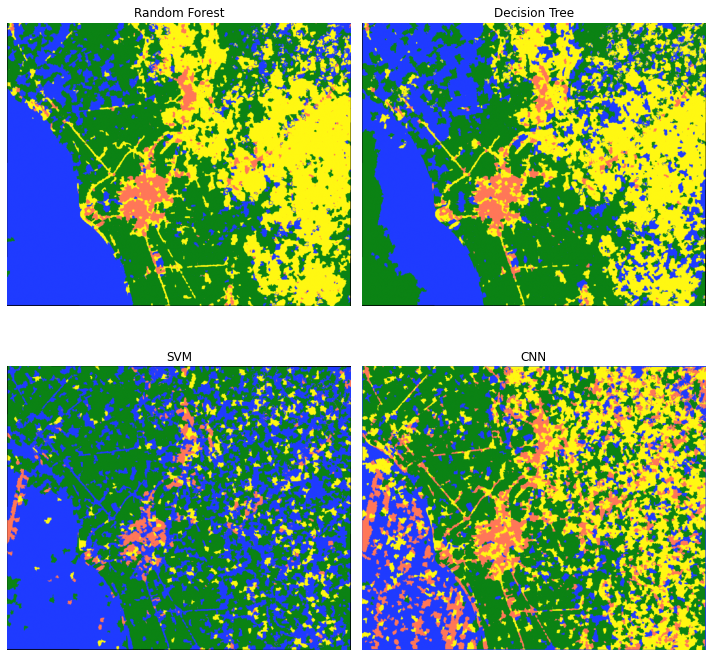

In [14]:
''' ============ Display ========== '''
def toRGB(z):
    rgb = np.zeros((z.shape[0], z.shape[1], 3))
    rgb[np.where(z == 1)] = [31, 59, 255]  # 0: water
    rgb[np.where(z == 2)] = [11, 131, 20]  # 1: vegetation
    rgb[np.where(z == 3)] = [255, 119, 88]  # 2: buildings
    rgb[np.where(z == 4)] = [255, 248, 18]  # 3: soil
    return rgb / 255

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

if run_RF:
    predMapRGB_RF = toRGB(clf_RF)
    plt.imsave(rootPath + "pred_RF.png", predMapRGB_RF)

    ax[0, 0].imshow(predMapRGB_RF)
    ax[0, 0].set_title("Random Forest")
if run_DT:
    predMapRGB_DT = toRGB(clf_DT)
    plt.imsave(rootPath + "pred_DT.png", predMapRGB_DT)
    
    ax[0, 1].imshow(predMapRGB_DT)
    ax[0, 1].set_title('Decision Tree')
if run_SVM:
    predMapRGB_SVM = toRGB(clf_SVM)
    plt.imsave(rootPath + "pred_SVM.png", predMapRGB_SVM)

    ax[1, 0].imshow(predMapRGB_SVM)
    ax[1, 0].set_title('SVM')
if run_CNN:
    predMapRGB_CNN = toRGB(clf_CNN)
    plt.imsave(rootPath + "pred_CNN.png", predMapRGB_CNN)

    ax[1, 1].imshow(predMapRGB_CNN)
    ax[1, 1].set_title('CNN')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [15]:
''' ====== Accuracy ======= '''
driver = gdal.GetDriverByName('MEM')
targetDS = driver.Create('', inputDS.RasterXSize, inputDS.RasterYSize, 1, gdal.GDT_UInt16)
targetDS.SetGeoTransform(inputDS.GetGeoTransform())
targetDS.SetProjection(inputDS.GetProjection())
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(targetDS, [1], testLyr, options=options)

truth = targetDS.GetRasterBand(1).ReadAsArray()
idx = np.nonzero(truth)

# Random Forest Accuracy
if run_RF:
    predDS_RF = gdal.Open(rootPath + 'classified_RF.tif')
    pred_RF = predDS_RF.GetRasterBand(1).ReadAsArray()
    
    cm_rf = metrics.confusion_matrix(truth[idx], pred_RF[idx])
    rf_accuracy = cm_rf.diagonal() / cm_rf.sum(axis=0)

    print("random forest", rf_accuracy)

# Decision Tree Accuracy
if run_DT:
    predDS_DT = gdal.Open(rootPath + 'classified_DT.tif')
    pred_DT = predDS_DT.GetRasterBand(1).ReadAsArray()
    
    cm_dt = metrics.confusion_matrix(truth[idx], pred_DT[idx])
    dt_accuracy = cm_dt.diagonal() / cm_dt.sum(axis=0)

    print("decision tree", dt_accuracy)

# SVM Accuracy
if run_SVM:
    predDS_SVM = gdal.Open(rootPath + 'classified_SVM.tif')
    pred_SVM = predDS_SVM.GetRasterBand(1).ReadAsArray()
    
    cm_svm = metrics.confusion_matrix(truth[idx], pred_SVM[idx])
    svm_accuracy = cm_svm.diagonal() / cm_svm.sum(axis=0)

    print("support vector machine", svm_accuracy)


# CNN Accuracy
if run_CNN:
    predDS_CNN = gdal.Open(rootPath + 'classified_CNN.tif')
    pred_CNN = predDS_CNN.GetRasterBand(1).ReadAsArray()

    cm_cnn = metrics.confusion_matrix(truth[idx], pred_CNN[idx])
    cnn_accuracy = cm_cnn.diagonal() / cm_cnn.sum(axis=0)

    print("convolutional neural network", cnn_accuracy)

random forest [0.84615385 0.92857143 0.91666667 1.        ]
decision tree [0.84615385 1.         0.9        0.76923077]
support vector machine [0.5        0.64285714 0.81818182 1.        ]
convolutional neural network [0.54545455 0.9        0.61111111 0.77777778]
